In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras import layers
from tensorflow import keras

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Predefining some variables
* Here we will be resizing images in 224x224 pixel format
* **Note:** Turn on your GPU Accelerator from more options (tensorflow uses GPU to speed up calculations)
* **Recommended to use:** GPU P100

In [2]:
TRAINING_PATH = '/kaggle/input/dogs-cats-images/dataset/training_set'
TEST_PATH = '/kaggle/input/dogs-cats-images/dataset/test_set'

IMG_WIDTH = 224
IMG_HEIGHT = 224
PIXELS = IMG_WIDTH*IMG_HEIGHT
RGB = 3
N = PIXELS*RGB

## Creating a Function for loading data
This Function will be used in forming the dataset

In [3]:
def create_image_dataframe(path):
    examples, labels = [], []
    for directory in os.listdir(path):
        examples += [os.path.join(path, directory, image) for image in os.listdir(os.path.join(path, directory))]
        labels += [directory.rstrip('s') for _ in range(len(os.listdir(os.path.join(path, directory))))]
    dataframe = pd.DataFrame({'imgpath': examples, 'label' : labels})
    dataframe = shuffle(dataframe)
    return dataframe.reset_index()

## Data PreProcessing

Creating a dataframe with paths for all images

In [4]:
training_dataframe = create_image_dataframe(TRAINING_PATH)
test_dataframe = create_image_dataframe(TEST_PATH)

valid_dataframe, test_dataframe = train_test_split(test_dataframe, test_size = 0.5)

print("Training Images: ", training_dataframe.shape[0])
print("Validating Images: ", valid_dataframe.shape[0])
print("Testing Images: ", test_dataframe.shape[0])

Training Images:  8000
Validating Images:  1000
Testing Images:  1000


### Data Overview (with samples)

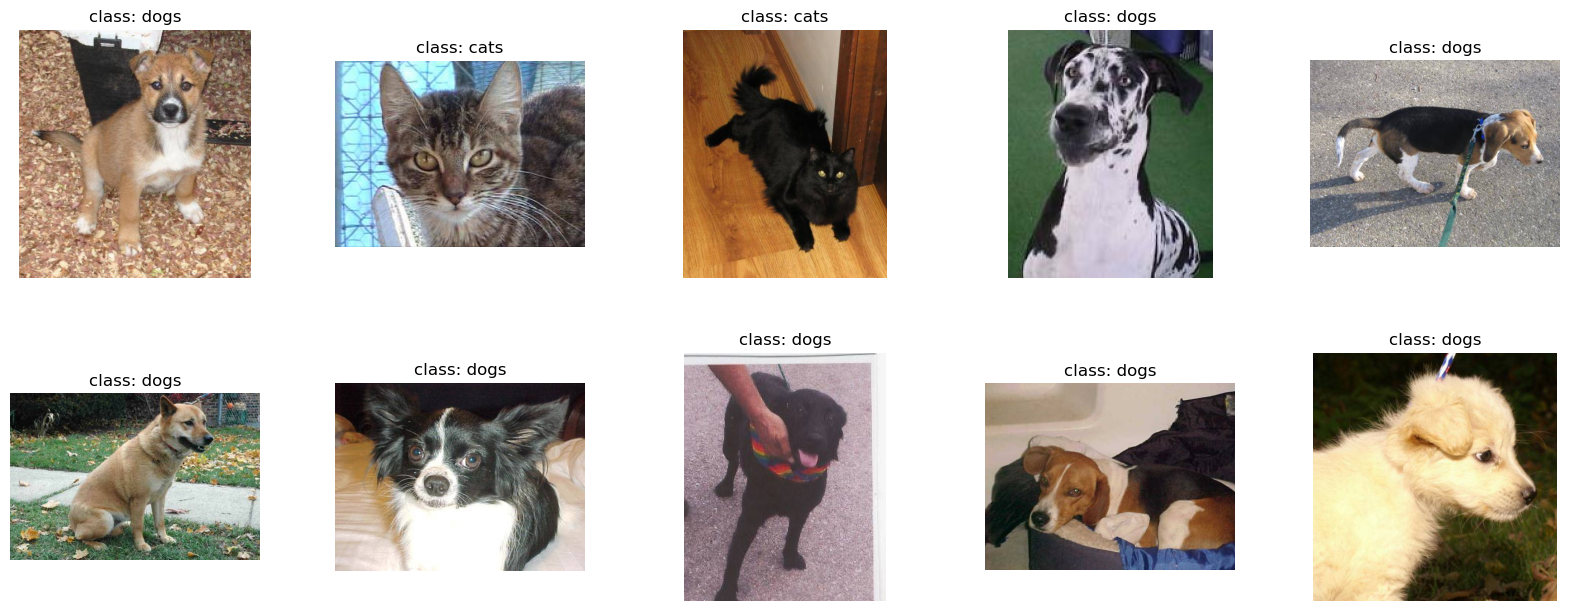

In [5]:
plt.figure(figsize=(20,20))
idx = random.randint(10,7999)
for i in range(idx-10, idx):
    image = tf.keras.utils.load_img(training_dataframe['imgpath'][i])
    label = training_dataframe['label'][i]+'s'
    plt.subplot(5,5,i-idx+10+1)
    plt.subplots_adjust(hspace=0.3,wspace = 0.3)
    plt.imshow(image)
    plt.title(f"class: {label}")
    plt.axis('off')

## Creating an Inception Network
I attempt to modify the VGG-16 network by replacing some the 3x3 and 5x5 CONV layers with Inception blocks with same total number of filters for each.

(The main aim of this notebook is to see if this modified version performs better than VGG-16)

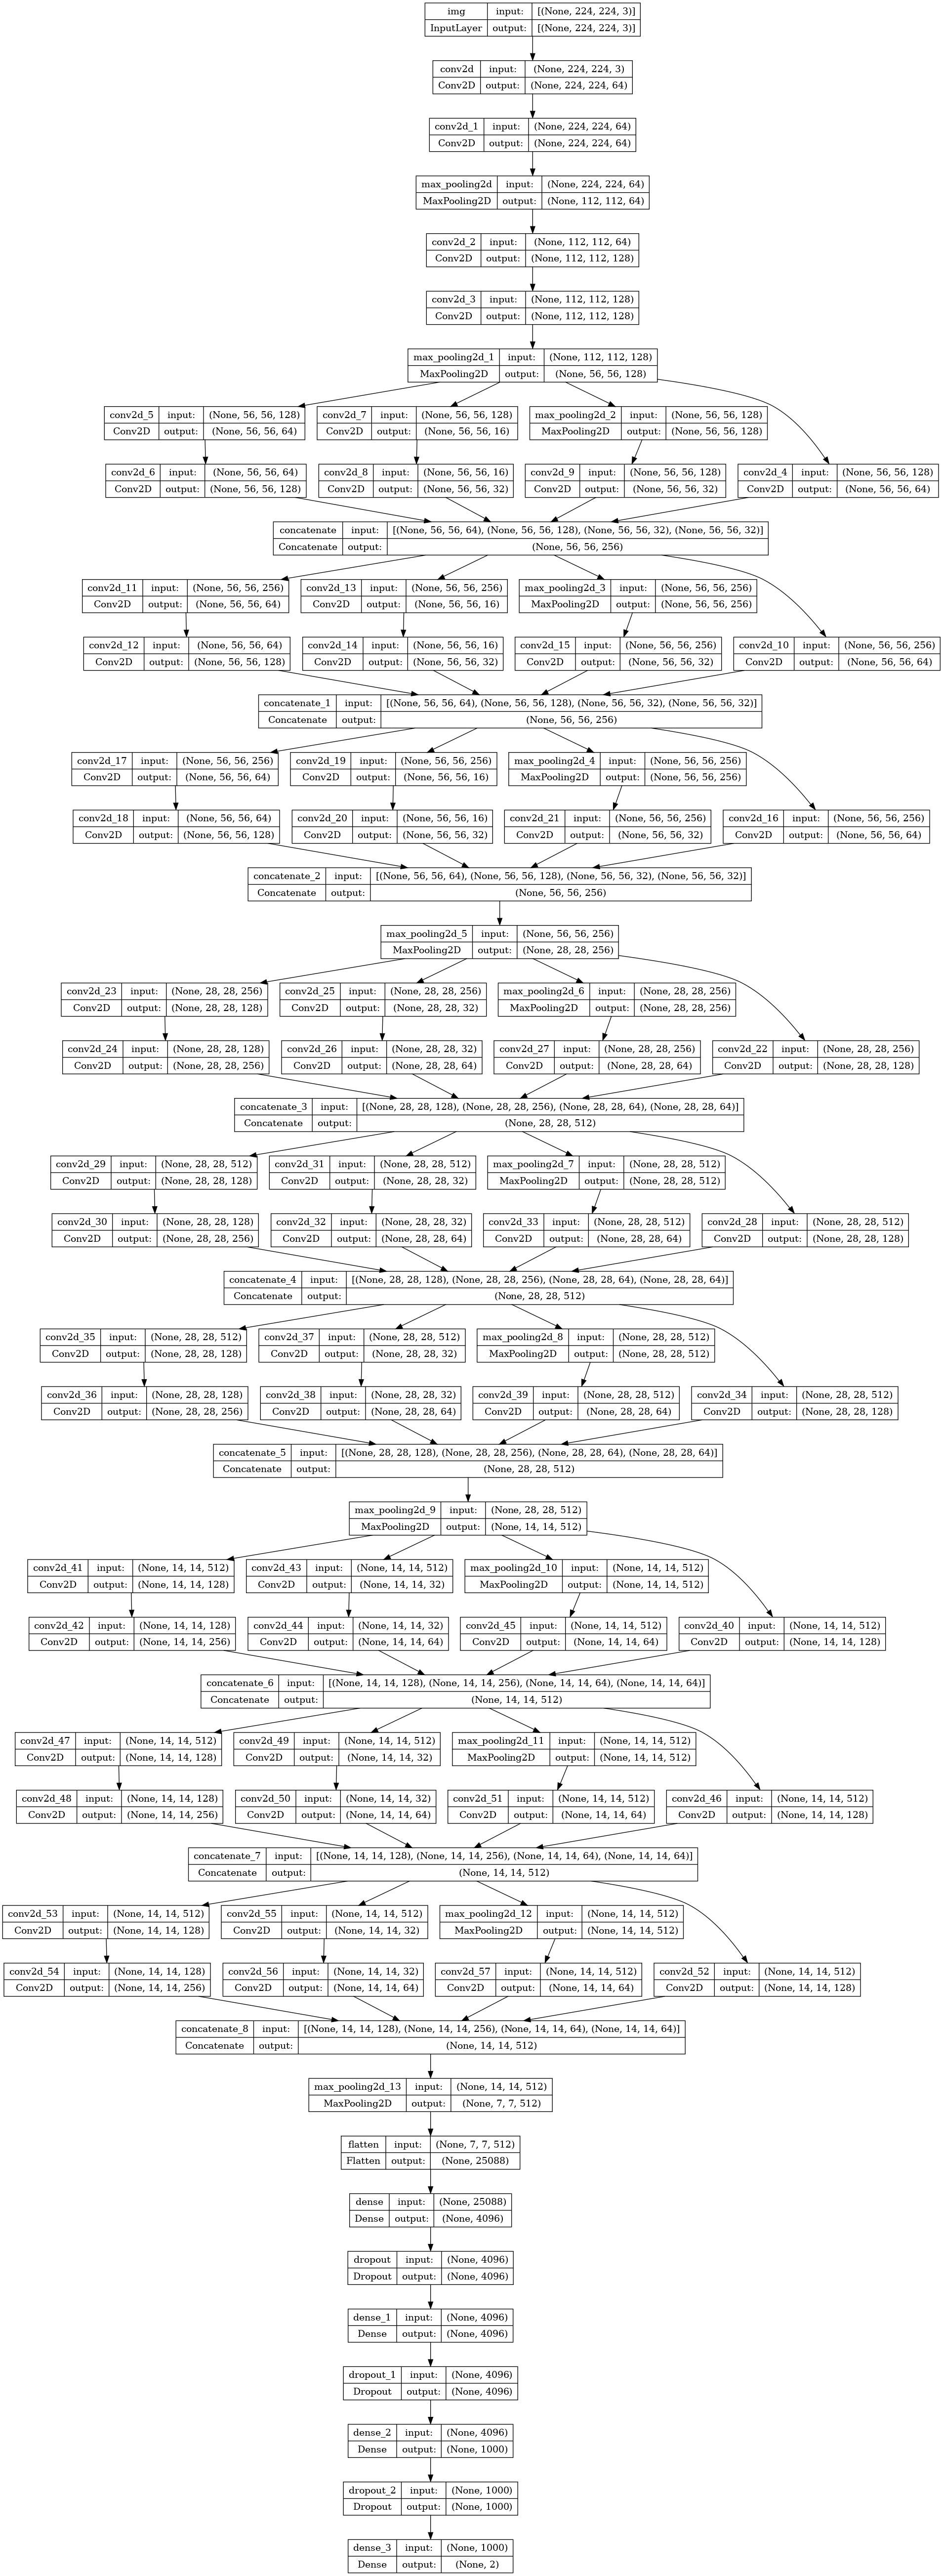

In [6]:
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, RGB), name="img")
x = layers.Conv2D(64, 3, activation="relu", padding = "same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", padding = "same")(x)
#x = layers.add([x, inputs])
x = layers.MaxPooling2D(2, strides = 2)(x)

x = layers.Conv2D(128, 3, activation="relu", padding = "same")(x)
x = layers.Conv2D(128, 3, activation="relu", padding = "same")(x)
#x = layers.add([x, inputs])
x = layers.MaxPooling2D(2, strides = 2)(x)

##Inception layers for replacing layers with 256 filters
for i in range(3):
    a1 = layers.Conv2D(64, 1, activation="relu")(x)
    a2 = layers.Conv2D(64, 1, activation="relu")(x)
    a2 = layers.Conv2D(128, 3, activation="relu", padding = "same")(a2)
    a3 = layers.Conv2D(16, 1, activation="relu")(x)
    a3 = layers.Conv2D(32, 5, activation="relu", padding = "same")(a3)
    a4 = layers.MaxPooling2D(3, strides = 1, padding = "same")(x)
    a4 = layers.Conv2D(32, 1, activation="relu")(a4)
    x = layers.concatenate([a1, a2, a3, a4])
x = layers.MaxPooling2D(2, strides = 2)(x)

##Inception layers for replacing layers with 512 filters
for i in range(6):
    a1 = layers.Conv2D(128, 1, activation="relu")(x)
    a2 = layers.Conv2D(128, 1, activation="relu")(x)
    a2 = layers.Conv2D(256, 3, activation="relu", padding = "same")(a2)
    a3 = layers.Conv2D(32, 1, activation="relu")(x)
    a3 = layers.Conv2D(64, 5, activation="relu", padding = "same")(a3)
    a4 = layers.MaxPooling2D(3, strides = 1, padding = "same")(x)
    a4 = layers.Conv2D(64, 1, activation="relu")(a4)
    x = layers.concatenate([a1, a2, a3, a4])
    if i==2:
        x = layers.MaxPooling2D(2, strides = 2)(x)
x = layers.MaxPooling2D(2, strides = 2)(x)
x = layers.Flatten()(x)

x = layers.Dense(4096, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(4096, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1000, activation="relu")(x)
x=layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

#x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
#x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
#block_2_output = layers.add([x, block_1_output])

#x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
#x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
#block_3_output = layers.add([x, block_2_output])

#x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
#x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dense(256, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
#outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="InceptVGG-16")
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

### Creating a Data Generator from in-built library using Data Augmentation

In [7]:
train_map = ImageDataGenerator(
                    rotation_range=10,
                    #zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    #width_shift_range=0.1,
                    #height_shift_range=0.1,
                    #rescale = 1/255
                    )

valid_map = ImageDataGenerator()
test_map =  ImageDataGenerator()

batch_size = 64

train_data = train_map.flow_from_dataframe(
            training_dataframe,
            x_col = 'imgpath',
            y_col = 'label',
            target_size = (IMG_HEIGHT, IMG_WIDTH),
            batch_size = batch_size,
            class_mode = 'categorical')

valid_data = valid_map.flow_from_dataframe(
             valid_dataframe,
             x_col = 'imgpath',
             y_col = 'label',
             target_size = (IMG_HEIGHT, IMG_WIDTH),
             batch_size = batch_size,
             class_mode = 'categorical')


test_data = test_map.flow_from_dataframe(
             test_dataframe,
             x_col = 'imgpath',
             y_col = None,
             target_size = (IMG_HEIGHT, IMG_WIDTH),
             batch_size = batch_size,
             class_mode = None,
             shuffle = False)

Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


In [8]:
valid_images = 1000
train_images = 8000
loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001,beta_1=0.9, beta_2=0.999,epsilon=1e-07)
metrics = ['accuracy']
model.compile(loss = loss, optimizer = opt, metrics = metrics)

history = model.fit(train_data, epochs = 25,
                          validation_data = valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size)

Epoch 1/25
125/125 [==============================] - 221s 1s/step - loss: 0.7377 - accuracy: 0.5536 - val_loss: 0.6740 - val_accuracy: 0.5385
Epoch 2/25
125/125 [==============================] - 130s 1s/step - loss: 0.6150 - accuracy: 0.6603 - val_loss: 0.5055 - val_accuracy: 0.7458
Epoch 3/25
125/125 [==============================] - 129s 1s/step - loss: 0.5164 - accuracy: 0.7440 - val_loss: 0.7404 - val_accuracy: 0.6781
Epoch 4/25
125/125 [==============================] - 130s 1s/step - loss: 0.4564 - accuracy: 0.7847 - val_loss: 0.4599 - val_accuracy: 0.7865
Epoch 5/25
125/125 [==============================] - 130s 1s/step - loss: 0.4012 - accuracy: 0.8150 - val_loss: 0.3799 - val_accuracy: 0.8302
Epoch 6/25
125/125 [==============================] - 128s 1s/step - loss: 0.3571 - accuracy: 0.8388 - val_loss: 0.3154 - val_accuracy: 0.8635
Epoch 7/25
125/125 [==============================] - 124s 989ms/step - loss: 0.3205 - accuracy: 0.8595 - val_loss: 0.2734 - val_accuracy: 0.8

### Plotting the Accuracy for Training and Validation

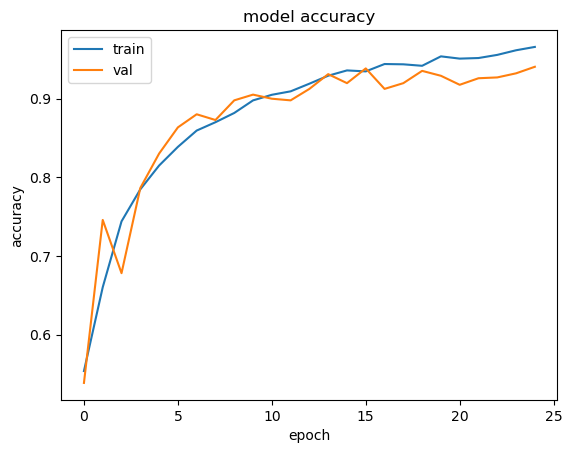

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Plotting the Loss for Training and Validation

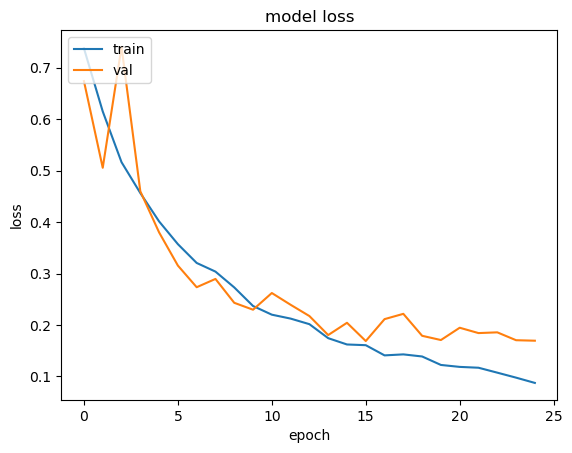

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Predicting on the test set

In [11]:
vani_pred_sub = model.predict_generator(test_data)
test_dataframe['pred_sub'] = np.argmax(vani_pred_sub, axis = -1)
labels = dict((v,k) for k,v in train_data.class_indices.items())
test_dataframe['pred_sub'] = test_dataframe['pred_sub'].map(labels)

/tmp/ipykernel_24/2335428339.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vani_pred_sub = model.predict_generator(test_data)


#### Showing the predictions through plotting

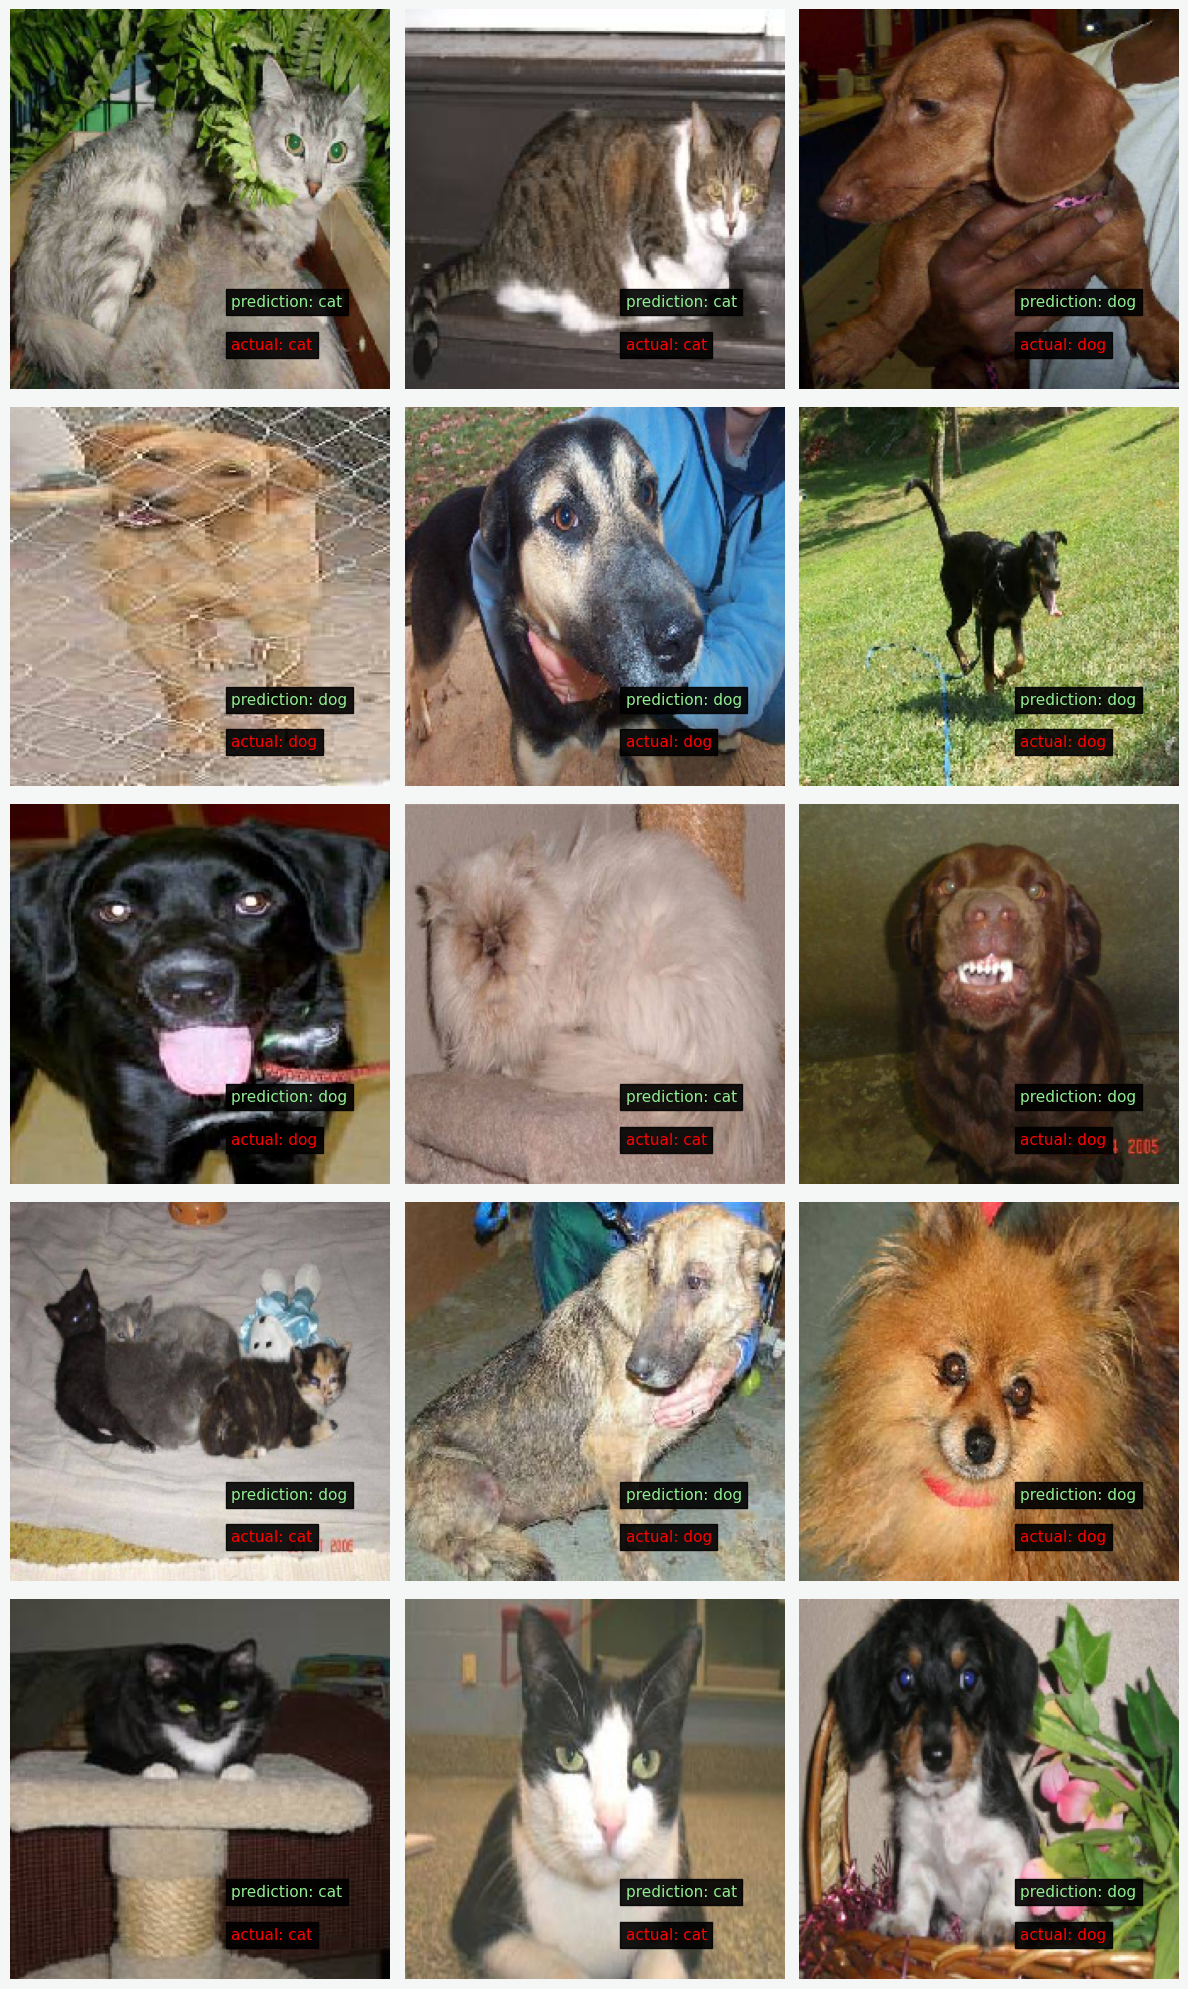

In [12]:
pred_sample = test_dataframe.sample(15)
pred_sample.reset_index(drop = True, inplace = True)

fig = plt.figure(figsize=(12,24))
fig.patch.set_facecolor('#f5f6f6')

for index, row in pred_sample.iterrows():
    filename = row['imgpath']
    pred = row['pred_sub']
    correct = row['label']
    img = load_img( filename, target_size= (IMG_HEIGHT, IMG_WIDTH))
    plt.subplot(6,3, index+1)
    plt.imshow(img)
    plt.gca().axis('off')
    plt.text(130, 175, 'prediction: {}'.format(pred), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(130, 200, 'actual: {}'.format(correct), color='red',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    #plt.title(filename.split('.')[0])
    del img
plt.tight_layout()